<a href="https://colab.research.google.com/github/MittalNeha/SchoolOfAI_EMLO/blob/main/7.%20Model%20Explainability/Session7_Adveserial_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
goal is to fool an already trained model.

https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

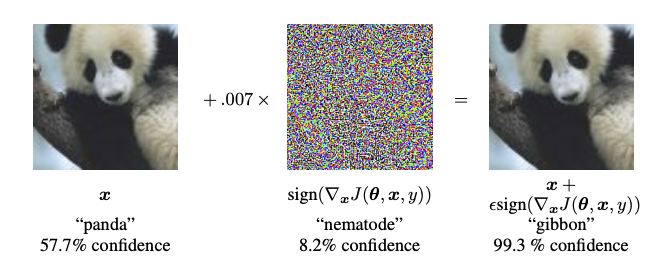

In [1]:
%pip install timm captum --quiet

     |████████████████████████████████| 1.4 MB 4.2 MB/s 


In [23]:
import timm
import urllib
import torch

import numpy as np

import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image

from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt

import os

In [3]:
from captum.robust import FGSM
from captum.robust import PGD

In [8]:
# device = torch.device("cuda")
device = torch.device("cpu")

In [4]:
# Download human-readable labels for ImageNet.
# get the classnames
url, filename = (
    "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
    "imagenet_classes.txt",
)
urllib.request.urlretrieve(url, filename)
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [ ]:
categories

In [5]:
cat_label = categories.index('Persian cat')

In [9]:
model = timm.create_model("resnet18", pretrained=True) #vgg11 #xception
model.eval()
model = model.to(device)

In [36]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=mean,
        std=std
    )
])

inv_transform= T.Compose([
    T.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
])

In [128]:
img = Image.open('./test_images/car.jpg')

img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)
img_tensor.requires_grad = True
img_tensor = img_tensor.to(device)

In [12]:
def get_prediction(model, image: torch.Tensor):
    model = model.to(device)
    img_tensor = image.to(device)
    with torch.no_grad():
        output = model(img_tensor)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)

    pred_label_idx.squeeze_()
    predicted_label = categories[pred_label_idx.item()]

    return predicted_label, prediction_score.squeeze().item()

In [20]:
def image_show(img, pred):
    npimg = inv_transform(img).squeeze().permute(1, 2, 0).detach().numpy()
    plt.axis('off')
    plt.imshow(npimg)
    plt.title("prediction: %s" % pred)
    plt.show()

In [ ]:
pgd = PGD(model, torch.nn.CrossEntropyLoss(reduction='none'), lower_bound=-1, upper_bound=1)  # construct the PGD attacker

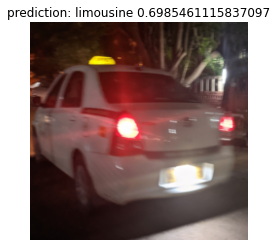

In [21]:
pred, score  = get_prediction(model, img_tensor)
image_show(img_tensor, pred + " " + str(score))

In [ ]:
perturbed_image_pgd = pgd.perturb(inputs=img_tensor, radius=0.13, step_size=0.02, 
                                  step_num=7, target=torch.tensor([cat_label]).to(device), targeted=True) 
new_pred_pgd, score_pgd = get_prediction(model, perturbed_image_pgd)

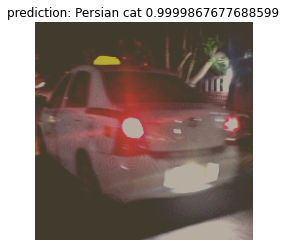

In [22]:
image_show(perturbed_image_pgd.cpu(), new_pred_pgd + " " + str(score_pgd))

In [26]:
def get_adveserial_image(img_path, new_pred_class):
    img = Image.open(img_path)

    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor.requires_grad = True
    img_tensor = img_tensor.to(device)

    perturbed_image_pgd = pgd.perturb(inputs=img_tensor, radius=0.13, step_size=0.02, 
                                  step_num=7, target=torch.tensor([new_pred_class]).to(device), targeted=True) 
    new_pred_pgd, score_pgd = get_prediction(model, perturbed_image_pgd)

    return perturbed_image_pgd

In [38]:
for img_name in os.listdir('test_images'):
    img_path = "test_images/"+img_name
    out_img_path = img_name[:img_name.rfind(".")] + "_adv" + ".jpg"
    adv_img = get_adveserial_image(img_path, cat_label)
    piltransform = T.ToPILImage()
    
    piltransform(inv_transform(adv_img).squeeze()).save(out_img_path)

# Robustness
1. Pixel Dropout
2. FGSM
3. Random Noise
4. Random Brightness

In [53]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


## Pixel Dropout

In [180]:
transform_dropout =  A.Compose([A.PixelDropout(0.3, always_apply=True, drop_value=0)])

In [181]:
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [182]:
def albumentation_totensor(img_tensor, transform):
    dropout_img = transform_dropout(image=np.array(img_tensor.detach().squeeze().permute(1, 2, 0).numpy()))["image"]
    img_tensor_d = torch.from_numpy(dropout_img)
    img_tensor_d = img_tensor_d.permute(2, 0, 1).unsqueeze(0)
    img_tensor_d.requires_grad = True
    img_tensor_d = img_tensor_d.to(device)

    return img_tensor_d

In [183]:
# img_tensor = transform(dropout_img)
img_tensor_d = albumentation_totensor(img_tensor, transform_dropout)

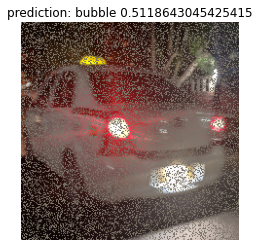

In [184]:
new_pred_drop, score_drop = get_prediction(model, img_tensor_d)
image_show(img_tensor_d, new_pred_drop + " " + str(score_drop))

## FGSM

In [129]:
fgsm = FGSM(model, lower_bound=-1, upper_bound=1)
perturbed_image_fgsm = fgsm.perturb(img_tensor, epsilon=0.16, target=285) 
new_pred_fgsm, score_fgsm = get_prediction(model, perturbed_image_fgsm)

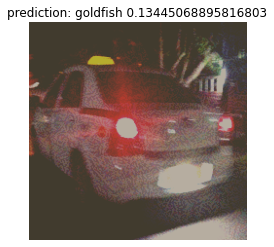

In [130]:
image_show(perturbed_image_fgsm.cpu(), new_pred_fgsm + " " + str(score_fgsm))

## Random Noise

In [132]:
transform_noise =  A.Compose([A.GaussNoise()])

In [154]:
img_tensor_n = albumentation_totensor(img_tensor, transform_noise)

(224, 224, 3)


In [155]:
img_tensor_n.shape

torch.Size([1, 3, 224, 224])

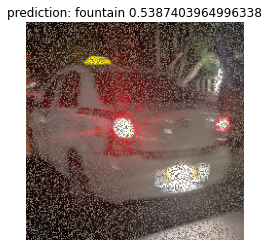

In [156]:
new_pred_noise, score_noise = get_prediction(model, img_tensor_n)
image_show(img_tensor_n, new_pred_noise + " " + str(score_noise))

In [177]:
transform_bright =  A.Compose([A.RandomBrightness(always_apply=True, p=1)])

In [178]:
img_tensor_b = albumentation_totensor(img_tensor, transform_bright)

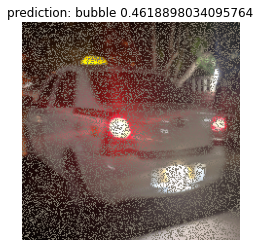

In [179]:
new_pred_bright, score_bright = get_prediction(model, img_tensor_b)
image_show(img_tensor_b, new_pred_bright + " " + str(score_bright))